In [1]:
import os
import sys

from pathlib import Path

# si aggiunge al path la cartella utils per avere visibilità del modulo
module_path = Path(os.getcwd()).parent.parent
module_path = os.path.join(module_path, "project-detective")

sys.path.append(module_path)

In [2]:
import cv2
import timm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import utils.semi_hard_mining as shm

from torch import nn
from tqdm import tqdm
from skimage import io
from pathlib import Path
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
# serve per ricaricare automaticamente il codice modificato
%load_ext autoreload
%autoreload 2

In [4]:
# directory da dove vengono prelevate le immagini
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="rgb"

BATCH_SIZE = 32

LR = 0.001

EPOCHS = 30

DEVICE = "cuda"

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")
print(f"Available devices: {torch.cuda.device_count()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.3.0+cu121
CUDA version: 12.1
cuDNN version: 8801
Available devices: 1
Device name: NVIDIA GeForce RTX 2050


In [5]:
csv_path = os.path.join("..", "datasets", "semi_hard_mining_database.csv")
df = pd.read_csv(csv_path)

df = df.sample(frac=1)

df.head()

train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

print(f"train dataset size: {len(train_df)}")
print(f"val dataset size: {len(valid_df)}")

train dataset size: 21044
val dataset size: 5261


In [6]:
# carica le immagini nel dataset
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    if mode == "rgb":
      # le immagini Anchor sono memorizzate in due dataset diversi
      if "tt" in row.Anchor:
        A_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        N_img = io.imread(os.path.join(real_data_dir, row.Negative))
      else:
        A_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(real_data_dir, row.Positive))
        N_img = io.imread(os.path.join(fake_data_dir, row.Negative))
          
      # normalizzazione per immagini in rgb 
      A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
      P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
      N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    if mode == "grey_scale":
      A_img = np.expand_dims(A_img, 0)
      P_img = np.expand_dims(P_img, 0)
      N_img = np.expand_dims(N_img, 0)
      
      A_img = torch.from_numpy(A_img) / 255.0
      P_img = torch.from_numpy(P_img) / 255.0
      N_img = torch.from_numpy(N_img) / 255.0

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [7]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
print(f"trainset size: {len(trainset)}")
print(f"validset size: {len(validset)}")

trainset size: 21044
validset size: 5261


In [8]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [9]:
print(f"#batches in trainloader : {len(trainloader)}")
print(f"#batches in validloader : {len(validloader)}")

#batches in trainloader : 658
#batches in validloader : 165


In [10]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model_Pretrained(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model_Pretrained, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [11]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [12]:
model = APN_Model_Pretrained()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(DEVICE)

APN_Model_Pretrained(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
      

In [13]:
# funzione di train
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  # on dropout 
  total_loss = 0.0

  for A, P, N in tqdm(dataloader, desc="model training..."):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    # criterion è la funzione di loss triplet
    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [14]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion):
  model.eval() 
  # off dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader, desc="model validating..."):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

  return total_loss / len(dataloader)

In [15]:
# triplet loss e adam
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [16]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []


for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model training...:   0%|          | 0/658 [00:00<?, ?it/s]C:\Users\acali\anaconda3\envs\fvabdetective\lib\site-packages\timm\layers\conv2d_same.py:27: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(x, weight, bias, stride, (0, 0), dilation, groups)
model validating...: 100%|██████████| 165/165 [01:47<00:00,  1.53it/s]


successful weights saving...
epochs: 1, train_loss: 0.3417966203950912, valid_loss: 0.2642098236716155


model validating...: 100%|██████████| 165/165 [01:26<00:00,  1.92it/s]


successful weights saving...
epochs: 2, train_loss: 0.21897527525105193, valid_loss: 0.20415545817125927


model validating...: 100%|██████████| 165/165 [01:23<00:00,  1.98it/s]


epochs: 3, train_loss: 0.18584382018827378, valid_loss: 0.38851350758111836


model validating...: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s]


epochs: 4, train_loss: 0.12749878007431703, valid_loss: 0.24325132968299318


model validating...: 100%|██████████| 165/165 [01:24<00:00,  1.96it/s]


epochs: 5, train_loss: 0.17422393373125955, valid_loss: 0.24461340822956779


model validating...: 100%|██████████| 165/165 [01:26<00:00,  1.91it/s]


successful weights saving...
epochs: 6, train_loss: 0.140860274088736, valid_loss: 0.1443800622766668


model validating...: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s]


epochs: 7, train_loss: 0.0778229125834843, valid_loss: 0.18810460727774736


model validating...: 100%|██████████| 165/165 [01:24<00:00,  1.96it/s]


epochs: 8, train_loss: 0.06566807240428896, valid_loss: 0.2328636837615208


model validating...: 100%|██████████| 165/165 [01:26<00:00,  1.90it/s]


epochs: 9, train_loss: 0.10690870267936342, valid_loss: 0.1850848153007753


model validating...: 100%|██████████| 165/165 [01:26<00:00,  1.91it/s]


epochs: 10, train_loss: 0.08732961677014828, valid_loss: 0.15239160738208077


model validating...: 100%|██████████| 165/165 [01:26<00:00,  1.91it/s]


successful weights saving...
epochs: 11, train_loss: 0.07120828921014959, valid_loss: 0.12921440242366358


model validating...: 100%|██████████| 165/165 [01:27<00:00,  1.90it/s]


epochs: 12, train_loss: 0.09090363938576544, valid_loss: 0.21770371523770418


model validating...: 100%|██████████| 165/165 [01:24<00:00,  1.96it/s]


epochs: 13, train_loss: 0.09216862426586675, valid_loss: 0.17930763320940912


model validating...: 100%|██████████| 165/165 [01:26<00:00,  1.90it/s]


epochs: 14, train_loss: 0.05264703161437008, valid_loss: 0.13539830538811107


model validating...: 100%|██████████| 165/165 [01:35<00:00,  1.73it/s]


epochs: 15, train_loss: 0.04198800976809941, valid_loss: 0.17990208362991159


model validating...: 100%|██████████| 165/165 [01:27<00:00,  1.89it/s]


epochs: 16, train_loss: 0.07613248243860017, valid_loss: 0.14968575058561384


model validating...: 100%|██████████| 165/165 [01:27<00:00,  1.89it/s]


successful weights saving...
epochs: 17, train_loss: 0.046600068707053056, valid_loss: 0.10998405799495452


model validating...: 100%|██████████| 165/165 [01:27<00:00,  1.89it/s]


successful weights saving...
epochs: 18, train_loss: 0.025946238788699668, valid_loss: 0.10777516326669491


model validating...: 100%|██████████| 165/165 [01:27<00:00,  1.89it/s]


epochs: 19, train_loss: 0.026575836548326952, valid_loss: 0.11627873283895579


model validating...: 100%|██████████| 165/165 [01:24<00:00,  1.96it/s]


epochs: 20, train_loss: 0.07618358542740708, valid_loss: 0.17115506295001867


model validating...: 100%|██████████| 165/165 [01:23<00:00,  1.98it/s]


epochs: 21, train_loss: 0.05466797143945578, valid_loss: 0.11193630660347867


model validating...: 100%|██████████| 165/165 [01:26<00:00,  1.90it/s]


epochs: 22, train_loss: 0.049432333386121005, valid_loss: 0.1224093688482588


model validating...: 100%|██████████| 165/165 [01:23<00:00,  1.97it/s]


epochs: 23, train_loss: 0.03693742167465049, valid_loss: 0.1503548782205943


model validating...: 100%|██████████| 165/165 [01:28<00:00,  1.87it/s]


epochs: 24, train_loss: 0.03808905042730566, valid_loss: 0.23881817624875992


model validating...: 100%|██████████| 165/165 [01:26<00:00,  1.92it/s]


epochs: 25, train_loss: 0.047241918230287755, valid_loss: 0.14638674491734216


model validating...: 100%|██████████| 165/165 [01:26<00:00,  1.92it/s]


epochs: 26, train_loss: 0.020874802289264544, valid_loss: 0.15804856324737723


model validating...: 100%|██████████| 165/165 [01:26<00:00,  1.91it/s]


epochs: 27, train_loss: 0.027474142792195896, valid_loss: 0.13137156981410403


model validating...: 100%|██████████| 165/165 [01:25<00:00,  1.94it/s]


epochs: 28, train_loss: 0.02594593133901934, valid_loss: 0.18033150446911653


model validating...: 100%|██████████| 165/165 [01:23<00:00,  1.98it/s]


successful weights saving...
epochs: 29, train_loss: 0.036486542234508645, valid_loss: 0.10108079269076839


model validating...: 100%|██████████| 165/165 [01:26<00:00,  1.91it/s]

epochs: 30, train_loss: 0.029990883040210758, valid_loss: 0.13523792507070484


<function matplotlib.pyplot.show(close=None, block=None)>

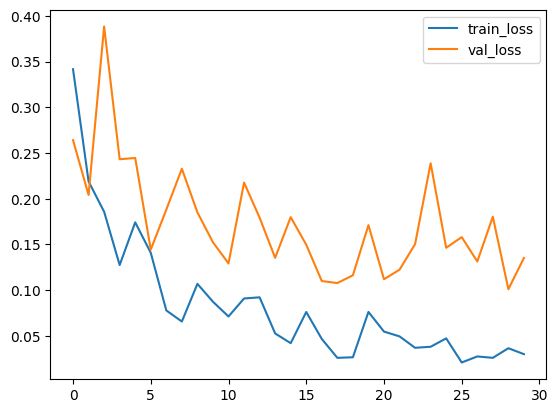

In [17]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [18]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):

      if mode == "rgb":
        # serve per trovare correttamente l'immagine
        if "tt" in i:
          dirFolder = fake_data_dir
          A = io.imread(os.path.join(dirFolder,i))
        else: 
          dirFolder = real_data_dir
          A = io.imread(os.path.join(dirFolder,i))

        A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      
      if mode == "grey_scale":
        A = io.imread(os.path.join(dirFolder,i))

        A = np.expand_dims(A, 0)
        A = torch.from_numpy(A.astype(np.int32)) / 255.0
        
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [19]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati per non rifarlo ad ogni allenamento
df_enc = get_encoding_csv(model, df["Anchor"], real_data_dir)

df_enc.to_csv("database.csv", index=False)

100%|██████████| 26305/26305 [08:23<00:00, 52.29it/s]


In [20]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,tt-cc/cin_k600_p1.0_a0.05_fid5.20/66/img031158...,-0.443623,-2.681223,-0.182675,-0.994985,-0.826632,0.935729,-1.390414,2.495621,0.155930,...,-0.104949,0.302053,0.494164,-0.908813,-0.780864,1.358823,0.001535,-0.617451,0.182214,0.148358
1,coco/coco2017/test2017/img000384.jpg,-0.460271,-2.707743,-0.181517,-1.004142,-0.812719,0.931079,-1.392462,2.519248,0.147601,...,-0.100484,0.278391,0.490532,-0.915005,-0.786209,1.383604,-0.012115,-0.599788,0.152903,0.136738
2,tt-ffhq/ffhq_k300_p1.0_fid9.6/img044108.jpg,-0.348787,-2.800112,-0.179044,-1.003753,-0.823446,0.895764,-1.389590,2.620988,0.164921,...,-0.096865,0.283081,0.509212,-0.917582,-0.777609,1.402059,0.010772,-0.590088,0.164810,0.145747
3,coco/coco2017/test2017/img040334.jpg,-0.086937,-2.651089,-0.183666,-1.014127,-0.831030,0.907112,-1.366081,2.503808,0.161595,...,-0.112706,0.302616,0.504314,-0.899613,-0.789887,1.382210,0.014531,-0.583223,0.187073,0.143895
4,coco/coco2017/test2017/img001049.jpg,-0.547328,-2.733925,-0.167866,-0.988938,-0.819270,0.926375,-1.402767,2.527264,0.160371,...,-0.099523,0.288020,0.489195,-0.907173,-0.782087,1.343076,-0.002662,-0.625776,0.171984,0.140629


In [21]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    #dist = np.sqrt(dist)
    return dist

In [22]:
path = os.path.join(Path(os.getcwd()).parent, "datasets", "testList.csv")
df = pd.read_csv(path)

print(df["real"])
print(df.size)
df.head()

0        coco/coco2017/test2017/img024751.jpg
1       coco/coco2017/train2017/img056531.jpg
2       coco/coco2017/train2017/img146024.jpg
3       coco/coco2017/train2017/img112797.jpg
4       coco/coco2017/train2017/img156023.jpg
                        ...                  
5256    coco/coco2017/train2017/img067559.jpg
5257    coco/coco2017/train2017/img074874.jpg
5258     coco/coco2017/test2017/img026796.jpg
5259     coco/coco2017/test2017/img038738.jpg
5260    coco/coco2017/train2017/img044098.jpg
Name: real, Length: 5261, dtype: object
10522


,real,fake
0,coco/coco2017/test2017/img024751.jpg,tt-coco/samples_nopix/img002713.jpg
1,coco/coco2017/train2017/img056531.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/185/img00484...
2,coco/coco2017/train2017/img146024.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img012790.jpg
3,coco/coco2017/train2017/img112797.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/106/img00048...
4,coco/coco2017/train2017/img156023.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img019108.jpg


In [23]:
def getImageEmbeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "grey_scale":
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [24]:
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [25]:
# DataTestReal = 'C:/Users/polsi/Desktop/Lavori/DeepFake/Datasets/Artifact/cycle_gan/st/test/'
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")

y_true = []
y_pred = []

tempDf = df
tempDf.head()
tempDf.shape

(5261, 2)

In [26]:
# testo i fake
currentTest = "fake"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on fake images..."):
    path = os.path.join(fake_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)

    if mode == "rgb":
        if str(closestLabel).startswith("tt"):
            y_pred.append("fake")
        else:
            y_pred.append("real")

    if mode == "grey_scale": 
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

testing on fake images...: 5261it [29:13,  3.00it/s]


In [27]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
5261
['real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 

In [28]:
# testo i real
currentTest = "real"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on real images..."):
    path = os.path.join(real_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)
    
    if mode == "rgb":
        if "tt" in closestLabel:
            y_pred.append("fake")
            
        else:
            y_pred.append("real")

    if mode == "grey_scale": 
        if "real" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")


testing on real images...: 5261it [29:19,  2.99it/s]


In [29]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
10522
['real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake',

In [30]:
# creo i vettori di ground truth
y_true = np.array(["fake"] * 5261)
print(y_true.shape)

temp = np.array(["real"] * 5261)
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

(5261,)
(5261,)
(10522,)
[[2941 2320]
 [2839 2422]]


In [31]:
TN, FP, FN, TP = cm.ravel()

# metriche
accuracy = round((TP + TN) / (TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 50.970000000000006, 'Precision': 51.080000000000005, 'Recall': 46.04, 'Specificity': 55.9019, 'F1 Score': 48.4292}


In [32]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "siamese_" + mode + "_" + dataset + "_results.csv")

df_results.to_csv(path, index=False)